### Demand Forecasting of Cement
### Analysis Data from 2010 to 2021 and forecast for 2022 til November


In [10]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 156)
pd.set_option('display.max_columns', 20)


## IMPORT DATA

In [11]:
df=pd.read_excel("Moving_Average.xlsx", sheet_name="Sheet1")

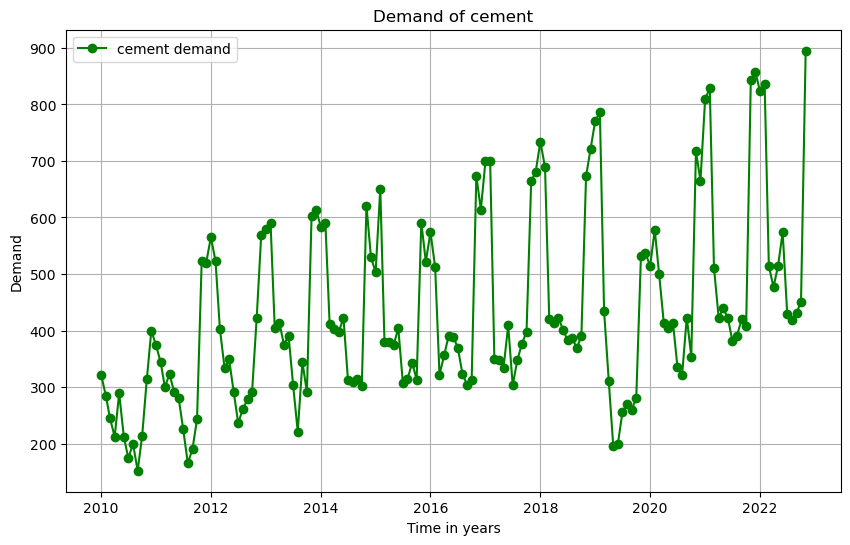

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df['Month'],df['Demand'], marker='o', linestyle='-', color='g', label='cement demand')
plt.xlabel('Time in years')
plt.ylabel('Demand')
plt.title('Demand of cement')
plt.legend()
plt.grid()
plt.show()

### MA(12) 

In [13]:
df['MA'] = np.nan

for i in range(df.shape[0]-23):
    idx = list(range(i + 1, i + 12))
    if i + 13 < df.shape[0]:  # Check if the index is within bounds
        df.loc[i + 6, "MA"] = (df.loc[i, 'Demand'] + df.loc[i + 12, 'Demand'] +2* np.sum(df.loc[idx, 'Demand']))/24
    else:
        df.loc[i + 6, "MA"] = (df.loc[i, 'Demand'] +2* np.sum(df.loc[idx, 'Demand']))/24

### finding initial level and trend

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
lr=LinearRegression()

In [16]:
idx=(range(6,138))
y = df.loc[idx, 'Demand']
x = (range(7,139))
x = np.array(x).reshape(-1, 1)  
y = np.array(y).reshape(-1, 1)

In [17]:
lr.fit(x,y)

LinearRegression()

In [18]:
level=lr.intercept_[0]
level

322.0287429190603

In [19]:
trend=lr.coef_[0][0]
trend

1.3928114874277997

### Deasonsonalized demand

In [20]:
idx=range(1,153)
df['Deseasonalized Demand']=df['No.']*trend+level

### Seasonal Factor

In [21]:
df['seasonal factor']=df['Demand']/df['Deseasonalized Demand']
for i in range(12):
        idx=range(i,df.shape[0],12)
        df.loc[i, 'SF']=np.average(df.loc[idx, 'seasonal factor'])


### finding Level Trend seasonal factor by winter method 

In [22]:
aplha=0.1
beta=0.1
gama=0.1

for i in range(df.shape[0]):
    if i==0:
        df.loc[i,'Level']=aplha*(df.loc[i,'Demand']/df.loc[i,'SF'])+(1-aplha)*(level+trend)
        df.loc[i,'Trend']=beta*(df.loc[i,'Level']-level) + (1-beta)*(trend)
#         df.loc[i,'SF']=gama*(df.loc[i,'Demand']/df.loc[i,'Level'])+(1-gama)*( df.loc[i,'SF'])
    else:
        df.loc[i,'Level']=aplha*(df.loc[i,'Demand']/df.loc[i,'SF'])+(1-aplha)*(df.loc[i-1,'Level']+df.loc[i-1,'Trend'])
        df.loc[i,'Trend']=beta*(df.loc[i,'Level']-df.loc[i-1,'Level'])+(1-beta)*(df.loc[i-1,'Trend'])
    if i+12<=df.shape[0]:
        df.loc[i+12,'SF']=gama*(df.loc[i,'Demand']/df.loc[i,'Level'])+(1-gama)*( df.loc[i,'SF'])
    

In [23]:
df=df.drop(df.index[-12:], axis=0)

## forecacted deamand ,deviation,Absolute deviation

In [24]:
df['Forecasted Deamand']=(df['Level']+df['Trend'])*df['SF']
df['Deviation']=df['Forecasted Deamand']-df['Demand']
df['Absolute Deviation']=np.abs(df['Deviation'])


### MSE

In [25]:
for i in range(df.shape[0]):
    idx=range(0,i+1)
    deviations = df.loc[idx,'Deviation']
    mse = np.mean(deviations ** 2)
    df.loc[i,'MSE'] = mse

### mean absolute deviation,MADi

In [26]:
cum=np.cumsum(df['Absolute Deviation'])
for i in range(df.shape[0]):
    df.loc[i,'MADi']=cum[i]/(i+1)


In [27]:
df['%Error']=100*(df['Absolute Deviation']/df['Demand'])

### Mean Absolute Percentage Error

In [28]:
mape=np.cumsum(df['%Error'])
for i in range(df.shape[0]):
    df.loc[i,'MAPEi']=mape[i]/(i+1)


### Tracking signal

In [29]:
error_cum=np.cumsum(df['Deviation'])
for i in range(df.shape[0]):
    df.loc[i,'Tracking signal']=error_cum[i]/df.loc[i,'MADi']

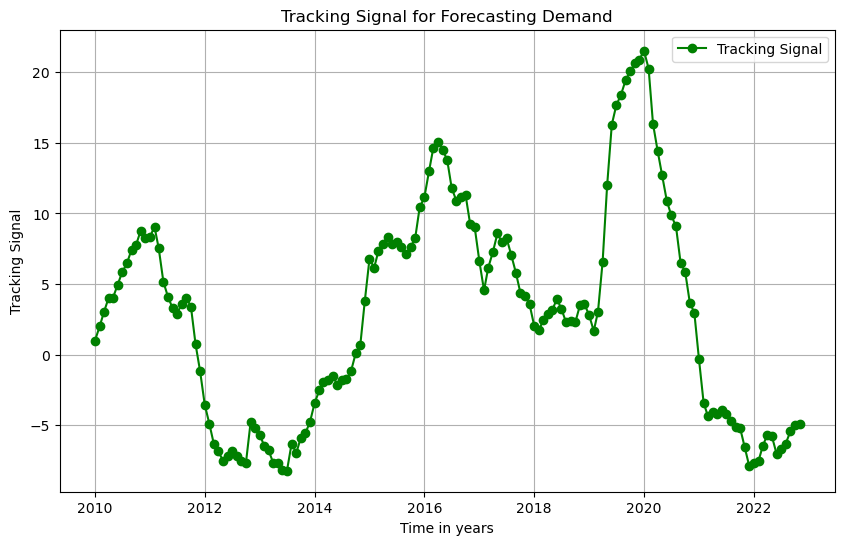

In [37]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df['Month'],df['Tracking signal'], marker='o', linestyle='-', color='g', label='Tracking Signal')
plt.xlabel('Time in years')
plt.ylabel('Tracking Signal')
plt.title('Tracking Signal for Forecasting Demand')
plt.legend()
plt.grid()
plt.show()

### Control Chart

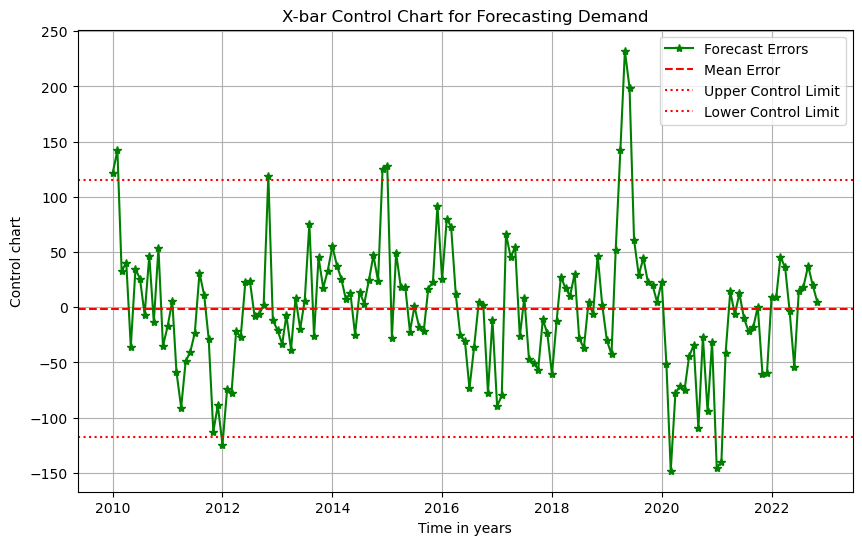

In [39]:
forecast_errors = df["Deviation"]
mean_error = np.mean(forecast_errors) #mean error
std_deviation = np.std(forecast_errors)
UCL= mean_error + 2 * std_deviation # Upper control limit
LCL = mean_error - 2 * std_deviation #lower control limit

plt.figure(figsize=(10, 6))
plt.plot(df["Month"], forecast_errors, marker='*', linestyle='-', color='g', label='Forecast Errors')
plt.axhline(y=mean_error, color='r', linestyle='--', label='Mean Error')
plt.axhline(y=UCL, color='r', linestyle=':', label='Upper Control Limit')
plt.axhline(y=LCL, color='r', linestyle=':', label='Lower Control Limit')
plt.xlabel('Time in years')
plt.ylabel('Control chart')
plt.title('X-bar Control Chart for Forecasting Demand')
plt.legend()
plt.grid()
plt.show()

In [40]:
df

,No.,Month,Demand,MA,Deseasonalized Demand,seasonal factor,SF,Level,Trend,Forecasted Deamand,Deviation,Absolute Deviation,MSE,MADi,%Error,MAPEi,Tracking signal
0,1.0,2010-01-01,322.0,NaN,323.421554,0.995605,1.411808,313.887037,0.439360,443.768448,121.768448,121.768448,14827.554909,121.768448,37.816288,37.816288,1.000000
1,2.0,2010-02-01,285.0,NaN,324.814366,0.877424,1.412500,303.070753,-0.686205,427.118061,142.118061,142.118061,17512.549028,131.943254,49.865986,43.841137,2.000000
2,3.0,2010-03-01,245.0,NaN,326.207177,0.751056,0.935169,298.344555,-1.090204,277.983184,32.983184,32.983184,12037.662838,98.956564,13.462524,33.714933,3.000000
3,4.0,2010-04-01,212.0,NaN,327.599989,0.647131,0.867845,291.957246,-1.619914,251.967748,39.967748,39.967748,9427.602348,84.209360,18.852711,29.999377,4.000000
4,5.0,2010-05-01,289.0,NaN,328.992800,0.878439,0.862569,294.808151,-1.172833,253.280826,-35.719174,35.719174,7797.253761,74.511323,12.359576,26.471417,4.041242
5,6.0,2010-06-01,212.0,NaN,330.385612,0.641674,0.857676,288.989738,-1.637391,246.455288,34.455288,34.455288,6695.572613,67.835317,16.252494,24.768263,4.946886
6,7.0,2010-07-01,174.0,253.750000,331.778423,0.524446,0.711074,283.087130,-2.063912,199.828380,25.828380,25.828380,5834.362984,61.834326,14.843896,23.350497,5.844681
7,8.0,2010-08-01,200.0,258.375000,333.171235,0.600292,0.690555,281.883101,-1.977924,193.289961,-6.710039,6.710039,5110.695689,54.943790,3.355020,20.851062,6.455541
8,9.0,2010-09-01,152.0,263.125000,334.564046,0.454323,0.735924,272.568957,-2.711546,198.594637,46.594637,46.594637,4784.069527,54.016107,30.654367,21.940318,7.429016
9,10.0,2010-10-01,214.0,270.041667,335.956858,0.636987,0.745701,271.569509,-2.540336,200.615251,-13.384749,13.384749,4323.577724,49.952971,6.254556,20.371742,7.765340
